# Main imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
import re
import pandas as pd
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
    import traci
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

from model_classes import ActorCriticNetwork, Agent, DQN

## Global variables for both models

In [2]:
n_actions = 5981
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
experiment_dict = {
    'dqn_base': {
        'weight_path_1_layer': './resultados_centro_1mlp/escenario0/1_layer/policy_net_weights_experiment_ep_2999.pt',
        'weight_path_2_layer': './resultados_centro_1mlp/escenario0/2_layer/policy_net_weights_experiment_ep_2999.pt',
        'weight_path_3_layer': './resultados_centro_1mlp/escenario0/3_layer/policy_net_weights_experiment_ep_2999.pt',
        'config': "../sumo_simulation/sim_config/km2_centro/scenario/osm.sumocfg",
        'plot_name': 'dqn_scenario_0'
    },
    'dqn_case_2x': {
        'weight_path_1_layer': './resultados_centro_1mlp/escenario1/1_layer/policy_net_weights_experiment_ep_2999.pt',
        'weight_path_2_layer': './resultados_centro_1mlp/escenario1/2_layer/policy_net_weights_experiment_ep_2999.pt',
        'weight_path_3_layer': './resultados_centro_1mlp/escenario1/3_layer/policy_net_weights_experiment_ep_2999.pt',
        'config': "../sumo_simulation/sim_config/km2_centro/scenario_2/osm.sumocfg",
        'plot_name': 'dqn_scenario_2',
    },
    'dqn_case_4x': {
        'weight_path_1_layer': './resultados_centro_1mlp/escenario2/1_layer/policy_net_weights_experiment_ep_2999.pt',
        'weight_path_2_layer': './resultados_centro_1mlp/escenario2/2_layer/policy_net_weights_experiment_ep_2999.pt',
        'weight_path_3_layer': './resultados_centro_1mlp/escenario2/3_layer/policy_net_weights_experiment_ep_2999.pt',
        'config': "../sumo_simulation/sim_config/km2_centro/scenario_3/osm.sumocfg",
        'plot_name': 'dqn_scenario_3'
    },
    'pg_base': {
        'weight_path_1_layer': './resultados_pg/escenario0/1_layer/ac_weights_experiment_ep_2999.pt',
        'weight_path_2_layer': './resultados_pg/escenario0/2_layer/ac_weights_experiment_ep_2999.pt',
        'weight_path_3_layer': './resultados_pg/escenario0/3_layer/ac_weights_experiment_ep_2999.pt',
        'config': "../sumo_simulation/sim_config/km2_centro/scenario/osm.sumocfg",
        'plot_name': 'scenario_0_pg'
    },
    'pg_2x': {
        'weight_path_1_layer': './resultados_pg/escenario1/1_layer/ac_weights_experiment_ep_2999.pt',
        'weight_path_2_layer': './resultados_pg/escenario1/2_layer/ac_weights_experiment_ep_2999.pt',
        'weight_path_3_layer': './resultados_pg/escenario1/3_layer/ac_weights_experiment_ep_1293.pt',
        'config': "../sumo_simulation/sim_config/km2_centro/scenario_2/osm.sumocfg",
        'plot_name': 'scenario_1_pg'
    },
    'pg_4x': {
        'weight_path_1_layer': './resultados_pg/escenario2/1_layer/ac_weights_experiment_ep_2999.pt',
        'weight_path_2_layer': './resultados_pg/escenario2/2_layer/ac_weights_experiment_ep_2999.pt',
        'weight_path_3_layer': './resultados_pg/escenario2/3_layer/ac_weights_experiment_ep_2192.pt',
        'config': "../sumo_simulation/sim_config/km2_centro/scenario_3/osm.sumocfg",
        'plot_name': 'scenario_2_pg'
    }
}

In [4]:
def load_dqn_sd(state_dict, num_layers):
    state_dict["mlp1.weight"] = state_dict['module.mlp1.weight']
    state_dict["mlp1.bias"] = state_dict['module.mlp1.bias']
    state_dict["head.weight"] = state_dict['module.head.weight']
    state_dict["head.bias"] = state_dict['module.head.bias']
    
    del state_dict['module.mlp1.weight'], state_dict['module.mlp1.bias'], state_dict['module.head.weight'], state_dict['module.head.bias']
    
    if num_layers == '1':
        policy_net = DQN(n_actions, False, False).to(device)
        
    elif num_layers == '2':
        policy_net = DQN(n_actions, True, False).to(device)
        state_dict["mlp2.weight"] = state_dict['module.mlp2.weight']
        state_dict["mlp2.bias"] = state_dict['module.mlp2.bias']
        
        del state_dict['module.mlp2.weight'], state_dict['module.mlp2.bias']
        
    else:
        policy_net = DQN(n_actions, True, True).to(device)
        state_dict["mlp2.weight"] = state_dict['module.mlp2.weight']
        state_dict["mlp2.bias"] = state_dict['module.mlp2.bias']
        state_dict["mlp3.weight"] = state_dict['module.mlp3.weight']
        state_dict["mlp3.bias"] = state_dict['module.mlp3.bias']
        
        del state_dict['module.mlp2.weight'], state_dict['module.mlp2.bias'], state_dict['module.mlp3.weight'], state_dict['module.mlp3.bias']
    

    policy_net.load_state_dict(state_dict)

    policy_net.eval()
    
    return policy_net

In [5]:
def load_pg_sd(state_dict, num_layers):
    if num_layers == '1':
        agent = Agent(alpha=0.001, input_dims=[6], gamma=0.001,
                  n_actions=n_actions, layer2_size=False, layer3_size=False)
   
    elif num_layers == '2':
        agent = Agent(alpha=0.001, input_dims=[6], gamma=0.001,
                  n_actions=n_actions, layer3_size=False)
    else:
        agent = Agent(alpha=0.001, input_dims=[6], gamma=0.001,
                  n_actions=n_actions)

    agent.actor_critic.load_state_dict(state_dict)

    agent.actor_critic.eval()
    
    return agent

In [6]:
def run_agent_simulation(key, weight_path, sumoCmd):
    
    num_layers = re.findall('\d', weight_path)
    
    if 'dqn' in key:
        num_layers = num_layers[2]
    else:
        num_layers = num_layers[1]
    
    state_dict = torch.load(weight_path)
    
    if 'dqn' in key:
        agent_kind = 'dqn'
        agent = load_dqn_sd(state_dict, num_layers)
    else:
        agent_kind = 'pg'
        agent = load_pg_sd(state_dict, num_layers)

    traci.start(sumoCmd)

    action_dict = cPickle.load(open('../sumo_simulation/input/action_to_zone_km2_centro.pkl', 'rb'))
    state = torch.zeros([1,6], device=device)
    traci_ep = 0
    lane_id_list = traci.lane.getIDList()

    states_agent = []
    states_agent_mean = []
    truck_emissions_agent = []

    for e in range(86400):

        if traci_ep % 3600 == 0 and traci_ep != 0:

            #Start agent interaction
            
            if agent_kind == 'dqn':
                action = agent(state)
            else:
                action = agent.choose_action(state)

            #Apply regulation and run steps
            reg_action = action > 0

            #print(reg_action.view(-1))

            for index, lane_id in enumerate(reg_action.view(-1)):
                        #for lane_id in lane_indices:
                if lane_id.item() == 1:
                    if action_dict[index] is not None:
                        traci.lane.setDisallowed(action_dict[index], ['truck'])
                    else:
                        pass
                else:
                    if action_dict[index] is not None:
                        traci.lane.setAllowed(action_dict[index], ['truck'])
                    else:
                        pass    

            vehicle_id_list = traci.vehicle.getIDList()
            
            vehicle_types = [traci.vehicle.getTypeID(v_id) for v_id in vehicle_id_list]
            vehicle_co2 = [traci.vehicle.getCO2Emission(v_id) for i, v_id in enumerate(vehicle_id_list) 
                                      if 'truck' in vehicle_types[i]]

            try:
                truck_emissions_agent.append(sum(vehicle_co2)/len(vehicle_co2))
            except:
                truck_emissions_agent.append(0)

            #Get simulation values
            co2 = [traci.lane.getCO2Emission(edge_id) for edge_id in lane_id_list]
            co = [traci.lane.getCOEmission(edge_id) for edge_id in lane_id_list]
            nox = [traci.lane.getNOxEmission(edge_id) for edge_id in lane_id_list]
            pmx = [traci.lane.getPMxEmission(edge_id) for edge_id in lane_id_list]
            noise = [traci.lane.getNoiseEmission(edge_id) for edge_id in lane_id_list]
            fuel = [traci.lane.getFuelConsumption(edge_id) for edge_id in lane_id_list]

            sim_results = np.array([co2, co, pmx, nox, noise, fuel])

            next_state = np.transpose(sim_results).mean(axis=0)
            
            states_agent.append(np.transpose(sim_results).sum(axis=0))
            states_agent_mean.append(next_state)

            next_state = torch.from_numpy(next_state).to(device).float()

            state += next_state

        traci.simulationStep()
        traci_ep += 1
    traci.close(False)
    
    if agent_kind == 'dqn':
        values = [agent(torch.from_numpy(state).float().to(device).view(-1,6)) 
                  for state in states_agent_mean]
    else:
        values = [agent.choose_action(torch.from_numpy(state).float().to(device).view(-1,6)) 
                  for state in states_agent_mean]
    
    
    #values = torch.cat(values).view(-1).detach().cpu().numpy()
    
    return states_agent, truck_emissions_agent, values

In [7]:
result_dict = {'{}_{}_layers'.format(algorithm, layer):'' 
               for algorithm in experiment_dict.keys() for layer in range(1,4)}

In [8]:
result_dict

{'dqn_base_1_layers': '',
 'dqn_base_2_layers': '',
 'dqn_base_3_layers': '',
 'dqn_case_2x_1_layers': '',
 'dqn_case_2x_2_layers': '',
 'dqn_case_2x_3_layers': '',
 'dqn_case_4x_1_layers': '',
 'dqn_case_4x_2_layers': '',
 'dqn_case_4x_3_layers': '',
 'pg_base_1_layers': '',
 'pg_base_2_layers': '',
 'pg_base_3_layers': '',
 'pg_2x_1_layers': '',
 'pg_2x_2_layers': '',
 'pg_2x_3_layers': '',
 'pg_4x_1_layers': '',
 'pg_4x_2_layers': '',
 'pg_4x_3_layers': ''}

In [9]:
for key in result_dict.keys():
    result_dict[key] = {k: '' for k in ['cauchy', 'chi_squared', 'gaussian']}

In [10]:
result_dict

{'dqn_base_1_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_base_2_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_base_3_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_case_2x_1_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_case_2x_2_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_case_2x_3_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_case_4x_1_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_case_4x_2_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'dqn_case_4x_3_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'pg_base_1_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'pg_base_2_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'pg_base_3_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'pg_2x_1_layers': {'cauchy': '', 'chi_squared': '', 'gaussian': ''},
 'pg_2x_2_layers': {'cauchy': '', 'chi_

In [11]:
plot_lanes = list(result_dict.keys())
#plot_lanes = ['dqn_base_2_layers', 'dqn_case_2x_3_layers', 'dqn_case_4x_3_layers', 'pg_base_1_layers']

In [12]:
for key in experiment_dict.keys():
    for path in experiment_dict[key]:
        if 'weight' in path:
            for test in ['cauchy', 'chi_squared', 'gaussian']:
                sumoCmd = ['/usr/bin/sumo/bin/sumo','-c',
             '/home/andres/Documents/tesis_pregrado/sumo_simulation/sim_config/test_cases/{}/osm.sumocfg'.format(test),
             '-e', '86400']
                if '_'.join([key,path.split('_')[2], 'layers']) in plot_lanes:
                    print(key, path, test)
                    result_dict['_'.join([key,path.split('_')[2], 'layers'])][test] = run_agent_simulation(key, experiment_dict[key][path], sumoCmd)

dqn_base weight_path_1_layer cauchy
 Retrying in 1 seconds
dqn_base weight_path_1_layer chi_squared
 Retrying in 1 seconds
dqn_base weight_path_1_layer gaussian
 Retrying in 1 seconds
dqn_base weight_path_2_layer cauchy
 Retrying in 1 seconds
dqn_base weight_path_2_layer chi_squared
 Retrying in 1 seconds
dqn_base weight_path_2_layer gaussian
 Retrying in 1 seconds
dqn_base weight_path_3_layer cauchy
 Retrying in 1 seconds
dqn_base weight_path_3_layer chi_squared
 Retrying in 1 seconds
dqn_base weight_path_3_layer gaussian
 Retrying in 1 seconds
dqn_case_2x weight_path_1_layer cauchy
 Retrying in 1 seconds
dqn_case_2x weight_path_1_layer chi_squared
 Retrying in 1 seconds
dqn_case_2x weight_path_1_layer gaussian
 Retrying in 1 seconds
dqn_case_2x weight_path_2_layer cauchy
 Retrying in 1 seconds
dqn_case_2x weight_path_2_layer chi_squared
 Retrying in 1 seconds
dqn_case_2x weight_path_2_layer gaussian
 Retrying in 1 seconds
dqn_case_2x weight_path_3_layer cauchy
 Retrying in 1 seconds


/home/andres/Documents/tesis_pregrado/notebooks/model_classes.py:68: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



pg_base weight_path_1_layer chi_squared
 Retrying in 1 seconds
pg_base weight_path_1_layer gaussian
 Retrying in 1 seconds
pg_base weight_path_2_layer cauchy
 Retrying in 1 seconds
pg_base weight_path_2_layer chi_squared
 Retrying in 1 seconds
pg_base weight_path_2_layer gaussian
 Retrying in 1 seconds
pg_base weight_path_3_layer cauchy
 Retrying in 1 seconds
pg_base weight_path_3_layer chi_squared
 Retrying in 1 seconds
pg_base weight_path_3_layer gaussian
 Retrying in 1 seconds
pg_2x weight_path_1_layer cauchy
 Retrying in 1 seconds
pg_2x weight_path_1_layer chi_squared
 Retrying in 1 seconds
pg_2x weight_path_1_layer gaussian
 Retrying in 1 seconds
pg_2x weight_path_2_layer cauchy
 Retrying in 1 seconds
pg_2x weight_path_2_layer chi_squared
 Retrying in 1 seconds
pg_2x weight_path_2_layer gaussian
 Retrying in 1 seconds
pg_2x weight_path_3_layer cauchy
 Retrying in 1 seconds
pg_2x weight_path_3_layer chi_squared
 Retrying in 1 seconds
pg_2x weight_path_3_layer gaussian
 Retrying in 

In [13]:
result_dict.keys()

dict_keys(['dqn_base_1_layers', 'dqn_base_2_layers', 'dqn_base_3_layers', 'dqn_case_2x_1_layers', 'dqn_case_2x_2_layers', 'dqn_case_2x_3_layers', 'dqn_case_4x_1_layers', 'dqn_case_4x_2_layers', 'dqn_case_4x_3_layers', 'pg_base_1_layers', 'pg_base_2_layers', 'pg_base_3_layers', 'pg_2x_1_layers', 'pg_2x_2_layers', 'pg_2x_3_layers', 'pg_4x_1_layers', 'pg_4x_2_layers', 'pg_4x_3_layers'])

In [14]:
for test in ['cauchy', 'gaussian', 'chi_squared']:
    for key in result_dict.keys():
        if '_'.join([key, 'layers']) in plot_lanes:
            plt.plot(result_dict[key][test][1], label='_'.join([key,test]))
            plt.legend()
    plt.show()

In [15]:
for tensor in result_dict['pg_base_1_layers']['gaussian'][2]:
    print(tensor.sum())

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., d

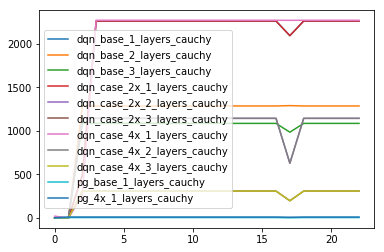

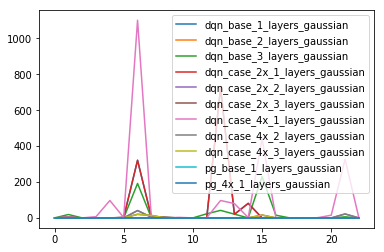

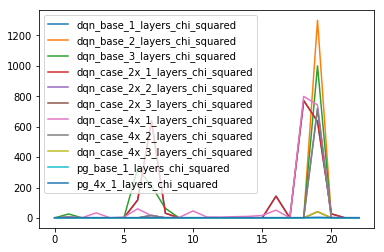

In [16]:
for test in ['cauchy', 'gaussian', 'chi_squared']:
    for key in result_dict.keys():
        if 'pg' in key and ('2' in key or '3' in key):
            continue
        if key in plot_lanes:
            if 'pg' in key:
                actions = [(t[0] > 0).sum().item() for t in result_dict[key][test][2]]
            else:
                actions = [(t > 0).sum().item() for t in result_dict[key][test][2]]
        
            plt.plot(actions, label='_'.join([key,test]))
            plt.legend()
    plt.show()

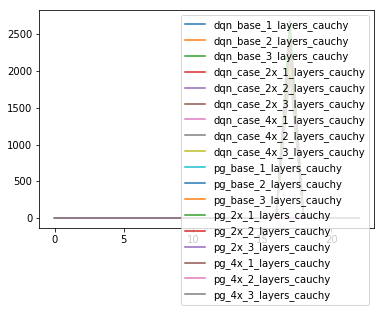

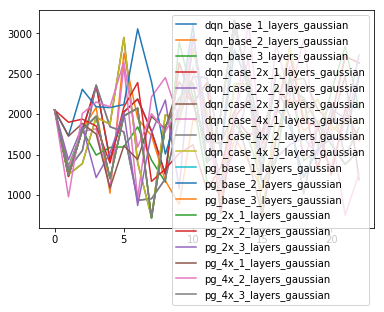

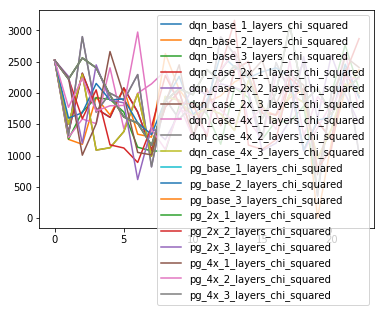

In [17]:
for test in ['cauchy', 'gaussian', 'chi_squared']:
    for key in result_dict.keys():
        if key in plot_lanes:
            plt.plot(result_dict[key][test][1], label='_'.join([key,test]))
            plt.legend()
    plt.show()

In [18]:
for test in ['cauchy', 'gaussian', 'chi_squared']:
    for key in result_dict.keys():
        if key in plot_lanes:
            print(key, test)
            print(list(np.array(result_dict[key][test][0]).sum(axis=0)))

dqn_base_1_layers cauchy
[380284.5711304015, 20350.675060837948, 11.303034915985634, 168.1272203123832, 4834.847449702776, 163.4748317001701]
dqn_base_2_layers cauchy
[216502.92906936756, 11302.00569633783, 6.292213280066899, 95.5382955965804, 3464.5846944698837, 93.06966414896004]
dqn_base_3_layers cauchy
[171863.07317399586, 8697.093358970298, 4.929754804050995, 74.9728875707299, 2811.233019588197, 73.87999569116907]
dqn_case_2x_1_layers cauchy
[380284.5711304015, 20350.675060837948, 11.303034915985634, 168.1272203123832, 4834.847449702776, 163.4748317001701]
dqn_case_2x_2_layers cauchy
[244348.94259967294, 12836.378285637482, 7.181351500968048, 107.39011601800193, 3354.109044886825, 105.03963766651813]
dqn_case_2x_3_layers cauchy
[44159.49374485842, 1546.7836265149301, 1.061878355832132, 18.26210940440237, 1135.0203897562394, 18.98348883677111]
dqn_case_4x_1_layers cauchy
[387187.04150843737, 20872.200309012278, 11.54992417580039, 171.3108828594158, 4663.497599842953, 166.4419919580

In [20]:
import pandas as pd

In [23]:
d = pd.DataFrame([np.array(result_dict[key]['cauchy'][0]).sum(axis=0) for key in result_dict.keys()],
            columns=['CO2', 'CO', 'PMx', 'NOx', 'Ruido', 'Consumo de Gasolina'])

In [25]:
d.to_latex()


'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &            CO2 &            CO &        PMx &         NOx &        Ruido &  Consumo de Gasolina \\\\\n\\midrule\n0  &  380284.571130 &  20350.675061 &  11.303035 &  168.127220 &  4834.847450 &           163.474832 \\\\\n1  &  216502.929069 &  11302.005696 &   6.292213 &   95.538296 &  3464.584694 &            93.069664 \\\\\n2  &  171863.073174 &   8697.093359 &   4.929755 &   74.972888 &  2811.233020 &            73.879996 \\\\\n3  &  380284.571130 &  20350.675061 &  11.303035 &  168.127220 &  4834.847450 &           163.474832 \\\\\n4  &  244348.942600 &  12836.378286 &   7.181352 &  107.390116 &  3354.109045 &           105.039638 \\\\\n5  &   44159.493745 &   1546.783627 &   1.061878 &   18.262109 &  1135.020390 &            18.983489 \\\\\n6  &  387187.041508 &  20872.200309 &  11.549924 &  171.310883 &  4663.497600 &           166.441992 \\\\\n7  &  244348.942600 &  12836.378286 &   7.181352 &  107.390116 &  3354.109045 &           105.

In [28]:
pd.DataFrame([np.array(result_dict[key]['gaussian'][0]).sum(axis=0) for key in result_dict.keys()],
            columns=['CO2', 'CO', 'PMx', 'NOx', 'Ruido', 'Consumo de Gasolina']).to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &           CO2 &            CO &        PMx &         NOx &         Ruido &  Consumo de Gasolina \\\\\n\\midrule\n0  &  1.128652e+06 &  63692.309693 &  63.271944 &  376.732680 &  26063.817087 &           485.219449 \\\\\n1  &  9.120655e+05 &  54019.635272 &  56.930743 &  303.723870 &  24852.665510 &           392.111014 \\\\\n2  &  9.145797e+05 &  52415.676147 &  54.787016 &  313.044760 &  24170.617132 &           393.193922 \\\\\n3  &  1.128652e+06 &  63692.309693 &  63.271944 &  376.732680 &  26063.817087 &           485.219449 \\\\\n4  &  9.717615e+05 &  55310.607532 &  59.729696 &  346.751741 &  24133.601385 &           417.775777 \\\\\n5  &  6.990338e+05 &  31565.241520 &  39.053071 &  215.918176 &  20825.224263 &           300.527861 \\\\\n6  &  1.151902e+06 &  66447.089477 &  69.359024 &  418.331315 &  26369.784043 &           495.215454 \\\\\n7  &  9.717615e+05 &  55310.607532 &  59.729696 &  346.751741 &  24133.601385 &           417.

In [29]:
pd.DataFrame([np.array(result_dict[key]['chi_squared'][0]).sum(axis=0) for key in result_dict.keys()],
            columns=['CO2', 'CO', 'PMx', 'NOx', 'Ruido', 'Consumo de Gasolina']).to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &           CO2 &            CO &        PMx &         NOx &         Ruido &  Consumo de Gasolina \\\\\n\\midrule\n0  &  1.218583e+06 &  72771.931485 &  73.672079 &  431.912853 &  28056.978840 &           523.888327 \\\\\n1  &  9.340166e+05 &  50663.922989 &  55.936284 &  319.435095 &  25599.945130 &           401.551673 \\\\\n2  &  9.548457e+05 &  56832.464984 &  58.845927 &  312.465494 &  26603.663656 &           410.507027 \\\\\n3  &  1.218583e+06 &  72771.931485 &  73.672079 &  431.912853 &  28056.978840 &           523.888327 \\\\\n4  &  1.036755e+06 &  54676.876924 &  59.498432 &  337.586391 &  25605.060218 &           445.715864 \\\\\n5  &  7.121777e+05 &  32898.856423 &  41.371322 &  224.739400 &  22156.572717 &           306.182925 \\\\\n6  &  1.160887e+06 &  70030.820914 &  68.774518 &  409.869232 &  27457.728910 &           499.086045 \\\\\n7  &  1.036755e+06 &  54676.876924 &  59.498432 &  337.586391 &  25605.060218 &           445.